# Generative Adversarial Network (GAN)

## Concept

GAN is composed of two neural networks that compete with each other, hence the name adversarial. There's the **Generator** network (G) and **Discriminator** network (D).

### Generator Network

The generator's task is to generate _fake data_ that could, hopefully, fool the discriminator. The generator does not have access to the _real data_ that the discriminator expects, instead it improves its ability to generate fake data by learning what feature of the data is expected by the discriminator.

- Input: vector of **noise**
- Output: fake data with the **same shape** as the real data

Stochastic gradient for generator network:

<center> $\bigtriangledown_{\theta_{d}}\frac{1}{m} \displaystyle\sum_{i=1}^{m}log (1-D(G(z^{(i)})))$ </center>

The target is to **minimize** the value of $1-D(G(z^{(i)}))$ which means **maximizing** the value of $D(G(z^{(i)})$, the probability that the discriminator passes the fake data generated by the generator as real.

### Discriminator Network

The discriminator's task is to determine if a data is _real_ or _fake_. The discriminator is actually updated by **ascending** its stochastic gradient, instead of descending.

- Input: real and fake **data**
- Output: binary (is the data real or fake)

Stochastic gradient for discriminator network:

<center> $\bigtriangledown_{\theta_{d}}\frac{1}{m} \displaystyle\sum_{i=1}^{m}[log D(x^{(i)}) + log (1-D(G(z^{(i)})))]$ </center>

## GAN for MNIST Dataset with Keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
class GAN():
    
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.noise_shape = (100,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.0002, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Image ---Discriminator--> Validity
        
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_model(self, version=None):
        if version is None:
            self.discriminator.save('gan/models/mnist-discriminator.h5')
            self.generator.save('gan/models/mnist-generator.h5')
            self.combined.save('gan/models/mnist-combined.h5')
        else:
            self.discriminator.save('gan/models/mnist-discriminator-{}.h5'.format(version))
            self.generator.save('gan/models/mnist-generator-{}.h5'.format(version))
            self.combined.save('gan/models/mnist-combined-{}.h5'.format(version))
        
        
    def load_model(self, version=None): 
        if version is None:
            self.discriminator = load_model('gan/models/mnist-discriminator.h5')
            self.generator = load_model('gan/models/mnist-generator.h5')
            self.combined = load_model('gan/models/mnist-combined.h5')
        else:
            self.discriminator = load_model('gan/models/mnist-discriminator-{}.h5'.format(version))
            self.generator = load_model('gan/models/mnist-generator-{}.h5'.format(version))
            self.combined = load_model('gan/models/mnist-combined-{}.h5'.format(version))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        model = Sequential()
        model.add(Dense(256, input_shape=self.noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
        model.add(Reshape(self.img_shape))
        
        model.summary()

        # Generator takes noise as an input and outputs an image
        noise = Input(shape=self.noise_shape)
        img = model(noise)

        return Model(noise, img)
    
    
    def train(self, epochs, batch_size=128, export_interval=250, save_model_interval=5000):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()        
        # X_train shape: (m, W, H)
        
        X_train = X_train[:40000]
        X_train = (X_train.astype(np.float32)) / 255
        
        # Change X_train's shape to (m, W, H, c)
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            # valid_y = np.array([1] * batch_size)
            valid_y = np.ones((batch_size, 1))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            with open('gan/logs/gan.log', 'a') as log_file:
                log_file.write('{},{}\n'.format(d_loss[0], g_loss))
            
            # Save generated samples at export_interval
            if epoch % export_interval == 0:
                r, c = 3, 3

                fig, axs = plt.subplots(r, c)
                
                prediction = self.discriminator.predict(gen_imgs)
                prediction = np.round(prediction)
                
                fooled_indices = []
                
                for i in range(len(prediction)):
                    if prediction[i] == 1:
                        fooled_indices.append(i)
                
                fooled_count = len(fooled_indices)
                
                # Export generated images that the discriminator classified as real
                cnt = 0
                if (fooled_count > 0):
                    for i in range(r):
                        for j in range(c):
                            if (cnt >= fooled_count):
                                break
                            axs[i,j].imshow(gen_imgs[fooled_indices[cnt], :,:,0], cmap='gray')
                            axs[i,j].axis('off')
                            cnt += 1
                            
                fig.savefig("gan/images/mnist_{}_fooled.png".format(epoch))
                plt.close()
                
                # Export generated images that the discriminator classified as fake
                fig, axs = plt.subplots(r, c)
                success_count = len(prediction) - fooled_count
                cnt = 0
                if (success_count > 0):
                    for i in range(r):
                        for j in range(c):
                            while cnt in fooled_indices:
                                cnt += 1
                            if (cnt >= success_count):
                                break
                            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                            axs[i,j].axis('off')
                            cnt += 1
                fig.savefig("gan/images/mnist_{}_detected.png".format(epoch))
                plt.close()
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_model(version=str(epoch))
                

# if __name__ == '__main__':
#     gan = GAN()
#     gan.train(epochs=30001, batch_size=64, export_interval=1000, save_model_interval=10000)

### Loading Saved GAN Model

In [3]:
gan_mse = GAN()
gan_mse.load_model(version='mse')

gan_bce = GAN()
gan_bce.load_model(version='bce')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/home/rionaldichandraseta/miniconda3/envs/gan-image/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

### Comparing GAN models with MSE and BCE

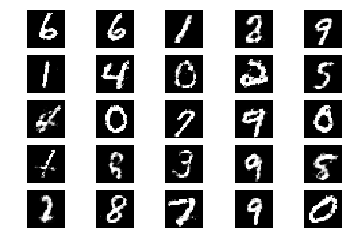

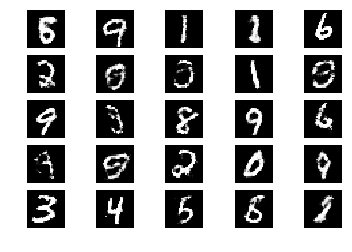

In [4]:
noise = np.random.normal(0, 1, (25, 100))

gen_imgs_mse = gan_mse.generator.predict(noise)
gen_imgs_bce = gan_bce.generator.predict(noise)

fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_mse[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
        
fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_bce[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1

## Build MNIST Classifier

In [5]:
def get_processed_dataset(n_train, n_test, n_class):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
        # Shapes:
        #   x_train, x_test = (m, W, H)
        #   y_train, y_test = (m)

    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
        # Shapes:
        #   x_train, x_test = (m, W, H, c)

    # Get normalized training data
    data_per_class = n_train / n_class
    count = np.zeros(10)
    new_x_train = np.empty_like(x_train)
    new_y_train = np.empty_like(y_train)
    new_x_train = new_x_train[:n_train]
    new_y_train = new_y_train[:n_train]
    it = 0
    for idx, label in enumerate(y_train):
        if count[label] >= data_per_class:
            pass
        else:
            new_x_train[it] = x_train[idx]
            new_y_train[it] = y_train[idx]
            count[label] += 1
            it += 1
            
    # Get normalized testing data
    data_per_class = n_test / n_class
    count = np.zeros(10)
    new_x_test = np.empty_like(x_test)
    new_y_test = np.empty_like(y_test)
    new_x_test = new_x_test[:n_test]
    new_y_test = new_y_test[:n_test]
    it = 0
    for idx, label in enumerate(y_test):
        if count[label] >= data_per_class:
            pass
        else:
            new_x_test[it] = x_test[idx]
            new_y_test[it] = y_test[idx]
            count[label] += 1
            it += 1
            
    new_x_train = new_x_train.astype('float32')
    new_x_test = new_x_test.astype('float32')

    new_x_train /= 255
    new_x_test /= 255
    
    new_y_train = to_categorical(new_y_train, n_class)
    new_y_test = to_categorical(new_y_test, n_class)
    
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [6]:
class MNISTClassifier():
    
    def __init__(self):
        self.n_class = 10
        
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channel)
        
        adam = Adam(lr=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=None,
                    decay=0.00001,
                    amsgrad=False)
        
        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer=adam,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    def save_model(self, version=None):
        if version is None:
            self.classifier.save('gan/models/mnist-classifier.h5')
        else:
            self.classifier.save('gan/models/mnist-classifier-{}.h5'.format(version))
            
    
    def load_model(self, version=None):
        if version is None:
            self.classifier = load_model('gan/models/mnist-classifier.h5')
        else:
            self.classifier = load_model('gan/models/mnist-classifier-{}.h5'.format(version))
        
        
    def build_classifier(self):
        model = Sequential()
        model.add(Conv2D(32,
                         kernel_size=(3,3),
                         activation='relu',
                         input_shape=self.img_shape,
                         data_format='channels_last'))
        model.add(Conv2D(64,
                         kernel_size=(3,3),
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128,
                        activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(self.n_class,
                        activation='softmax'))
        
        model.summary()
        
        return model
    
    def train(self, batch_size=400, epoch_limit=50, n_train=40000, version='conv'):
        n_train = n_train if n_train > 0 and n_train <= 60000 else 60000
        
        (x_train, y_train), (x_test, y_test) = get_processed_dataset(n_train, 10000, self.n_class)
        
        # --------
        # Training
        # --------

        history = self.classifier.fit(x_train, y_train,
                                     batch_size=batch_size,
                                     epochs=epoch_limit,
                                     verbose=1,
                                     validation_data=(x_test, y_test))

        self.save_model(version)
        
    def train_on_custom_dataset(self, x_train, y_train, batch_size=500, epoch_limit=50, version='conv-with-gan'):
        (_, _), (x_test, y_test) = get_processed_dataset(0, 10000, self.n_class)
        
        # --------
        # Training
        # --------
        
        history = self.classifier.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epoch_limit,
                                      verbose=1,
                                      validation_data=(x_test, y_test))
        
        self.save_model(version)

        
    def evaluate(self, n_test=9000):
        (x_train, y_train), (x_test, y_test) = get_processed_dataset(0, n_test, self.n_class)
        
        score = self.classifier.evaluate(x_test, y_test,
                                         verbose=1)
        print('Test Loss = {}, Test Accuracy = {}'.format(score[0], score[1]))
        
# if __name__ == '__main__':
#     conv = MNISTClassifier()
#     conv.train(epoch_limit=50)

## Export Generated Dataset (Image + Label)

In [7]:
def save_gen_data(gen_imgs, labels, file_name=None):
    file_name = file_name if file_name is not None else 'gen_imgs'
    path = 'gan/gen-images/'
    file_name = path + file_name
    file_name_x = file_name + '_x'
    file_name_y = file_name + '_y'
    
    np.save(file_name_x, gen_imgs)
    np.save(file_name_y, labels)
    
def load_gen_data(file_name):
    path = 'gan/gen-images/'
    file_name = path + file_name
    file_name_x = file_name + '_x.npy'
    file_name_y = file_name + '_y.npy'
    
    gen_imgs = np.load(file_name_x)
    labels = np.load(file_name_y)
    return (gen_imgs, labels)

# if __name__ == '__main__':
#     noise = np.random.normal(0, 1, (30000, 100))

#     gen_imgs = gan_mse.generator.predict(noise)

#     conv = MNISTClassifier()
#     conv.load_model('conv')
#     predictions = conv.classifier.predict(gen_imgs)

#     save_gen_data(gen_imgs, predictions, file_name='v2')

In [8]:
conv = MNISTClassifier()
conv.load_model('conv')

conv.evaluate()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

The model achieves 98.83% on the test set after training with the reduced original dataset

## Analyze Generated Data

In [9]:
(gen_imgs, labels) = load_gen_data(file_name='v1')

labels_clone = labels
threshold = 0.999
labels_clone = np.where(labels > threshold, 1, 0)

# Number of MNIST class
n_class = 10

below_threshold_indices = []
below_threshold_count = 0
for i in range (len(labels_clone)):
    all_zero = True
    for j in range (n_class):
        if all_zero:
            all_zero = labels_clone[i][j] == 0
        else:
            break
    if all_zero:
        below_threshold_count += 1
        below_threshold_indices.append(i)

print('Detected {} generated data that falls below the threshold of {}'.format(below_threshold_count, threshold))

failed_counts = np.zeros(10)
for index in below_threshold_indices:
    failed_counts[np.argmax(labels[index])] += 1
    
print('Label distribution for data below threshold: {}'.format(failed_counts))

above_threshold_indices = []
success_counts = np.zeros(10)
for idx, label in enumerate(labels):
    if idx not in below_threshold_indices:
        success_counts[np.argmax(label)] += 1
        above_threshold_indices.append(idx)
    
print('Label distribution for data above threshold: {}'.format(success_counts))

Detected 7181 generated data that falls below the threshold of 0.999
Label distribution for data below threshold: [ 456.  554.  594.  942.  597.  755.  532.  641.  983. 1127.]
Label distribution for data above threshold: [2887. 3532. 1129. 3010. 1571. 1700. 2073. 2327. 1940. 2650.]


### Samples of Data Below Threshold

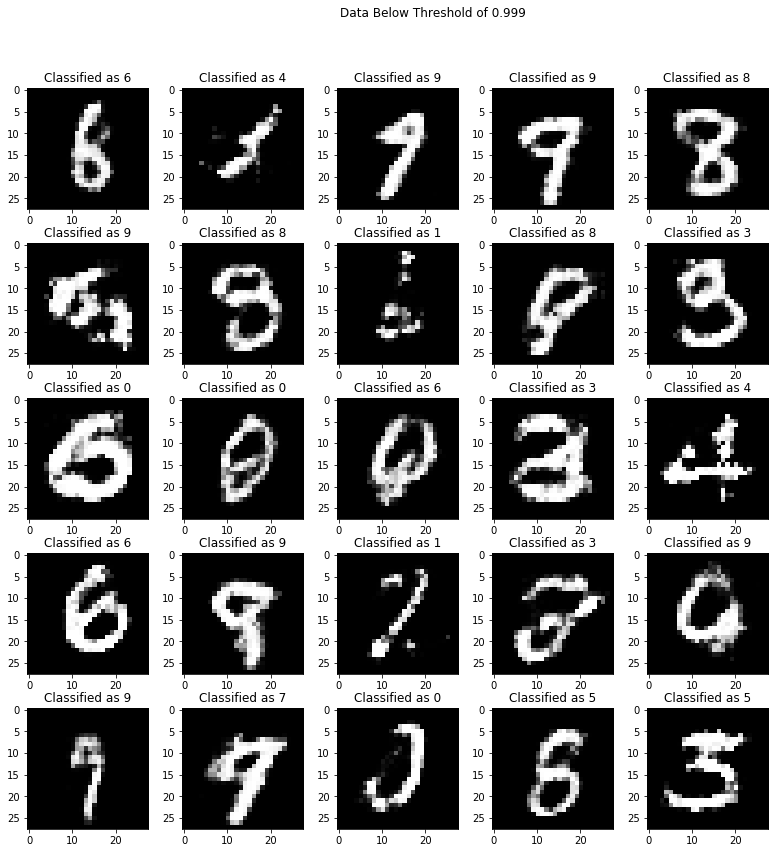

In [10]:
figure, ax = plt.subplots(5,5, figsize=(12, 12))
figure.suptitle('Data Below Threshold of {}'.format(threshold))
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

used_indices = []
for x, y in [(i, j) for i in range(5) for j in range(5)]:
    index = random.choice(below_threshold_indices)
    while index in used_indices:
        index = random.choice(below_threshold_indices)
    used_indices.append(index)
    # Check if the randomized index has been used this time
    ax[x, y].imshow(gen_imgs[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('Classified as {}'.format(np.argmax(labels[index])))

### Samples of Data Above Threshold

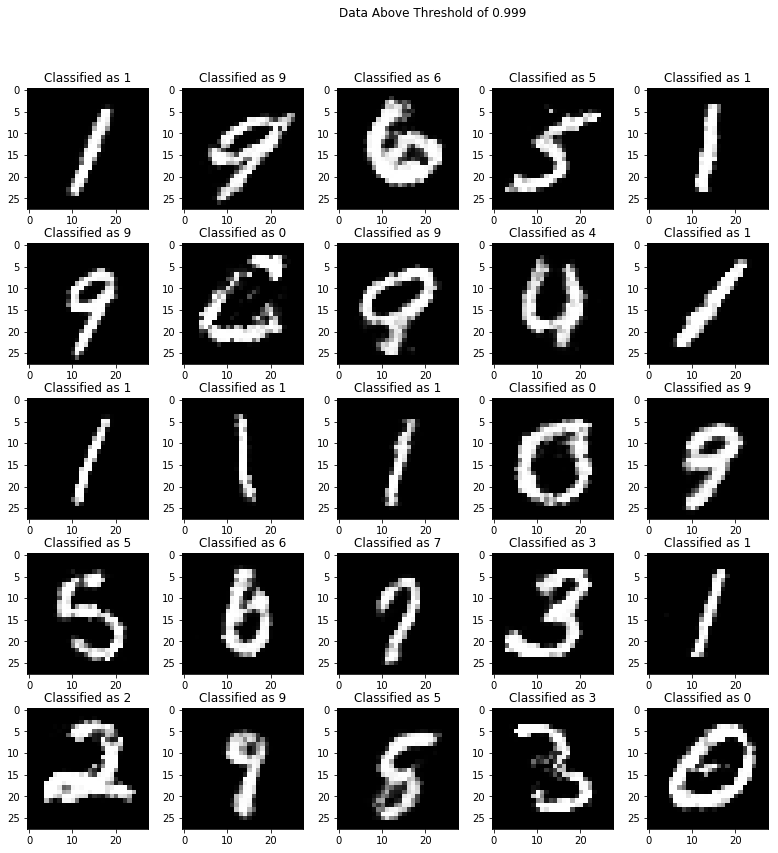

In [11]:
figure, ax = plt.subplots(5,5, figsize=(12, 12))
figure.suptitle('Data Above Threshold of {}'.format(threshold))
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

used_indices = []
for x, y in [(i, j) for i in range(5) for j in range(5)]:
    index = random.randint(0,len(labels))
    # Check if the randomized index has been used this time
    while index not in range(len(labels)):        
        while index in used_indices or index in failed_indices:
            index += 1
        if index >= len(labels):
            index = random.randint(0,len(labels))
    used_indices.append(index)
    ax[x, y].imshow(gen_imgs[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('Classified as {}'.format(np.argmax(labels[index])))

### Concatenate Generated Data to Original Dataset

In [12]:
def normalize_data(x_train, y_train, above_threshold_indices, n_train=10000, n_class=10):
    # Shapes:
    #   x_train = (m, W, H, c)
    #   y_train = (m)
    
    # Get normalized training data
    data_per_class = n_train / n_class
    count = np.zeros(10)
    new_x_train = np.empty_like(x_train)
    new_y_train = np.empty_like(y_train)
    new_x_train = new_x_train[:n_train]
    new_y_train = new_y_train[:n_train]
    it = 0
    for idx in above_threshold_indices:
        if count[int(y_train[idx])] >= data_per_class:
            pass
        else:
            new_x_train[it] = x_train[idx]
            new_y_train[it] = y_train[idx]
            count[int(y_train[idx])] += 1
            it += 1
            
    new_x_train = new_x_train.astype('float32')
    new_x_train /= 255
    new_y_train = to_categorical(new_y_train, n_class)
    
    return (new_x_train, new_y_train)

In [13]:
(gen_imgs, predictions) = load_gen_data(file_name='v1')


# Find indices of data below and above threshold

labels_clone = predictions
threshold = 0.999
labels_clone = np.where(labels_clone > threshold, 1, 0)

below_threshold_indices = []
below_threshold_count = 0
for i in range (len(labels_clone)):
    all_zero = True
    for j in range (n_class):
        if all_zero:
            all_zero = labels_clone[i][j] == 0
        else:
            break
    if all_zero:
        below_threshold_count += 1
        below_threshold_indices.append(i)

above_threshold_indices = []
success_counts = np.zeros(10)
for idx, label in enumerate(labels_clone):
    if idx not in below_threshold_indices:
        success_counts[np.argmax(label)] += 1
        above_threshold_indices.append(idx)


# Convert to labels for processing

labels = np.empty((len(predictions)))
for idx, prediction in enumerate(predictions):
    labels[idx] = np.argmax(predictions[idx])

(new_x_train, new_y_train) = normalize_data(gen_imgs, labels, above_threshold_indices)

labels = np.empty((len(new_y_train)))
for idx, label in enumerate(new_y_train):
    labels[idx] = np.argmax(label)

count = np.zeros(10)
for label in labels:
    count[int(label)] += 1
    
print('Generated data distribution:\n{}'.format(count))

Generated data distribution:
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [22]:
(x_train, y_train), (_, _) = get_processed_dataset(40000, 0, 10)

x_train = np.concatenate((x_train, new_x_train), axis=0)
y_train = np.concatenate((y_train, new_y_train), axis=0)

new_conv = MNISTClassifier()
new_conv.train_on_custom_dataset(x_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

50000/50000 [==============================] - 109s 2ms/step - loss: 0.0088 - acc: 0.9971 - val_loss: 0.1303 - val_acc: 0.9713
Epoch 50/50
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0092 - acc: 0.9968 - val_loss: 0.1293 - val_acc: 0.9708
